In [2]:
# imports
import numpy as np
from facenet_pytorch import MTCNN
import pdb
import torch
from torchvision.transforms import ToTensor, Resize
from PIL import Image
import matplotlib.pyplot as plt
import os.path
import utils

# autoreload
%load_ext autoreload
%autoreload 2

<Figure size 432x288 with 0 Axes>

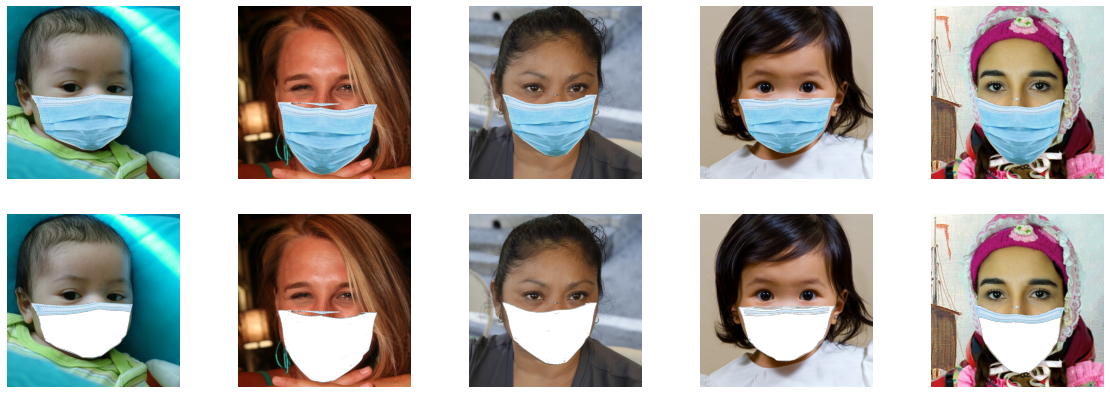

In [6]:
# parameters
num_faces = 20
masked_dir = '../data/masked_projection'
masked_suffix = '_Mask.jpg'
transparent_dir = '../data/transparent'
transparent_suffix = '_Mask.png'

# load faces
masked_faces, transparent_faces = utils.load_faces(
    num_faces,
    masked_dir,
    masked_suffix,
    transparent_dir,
    transparent_suffix
)

<Figure size 432x288 with 0 Axes>

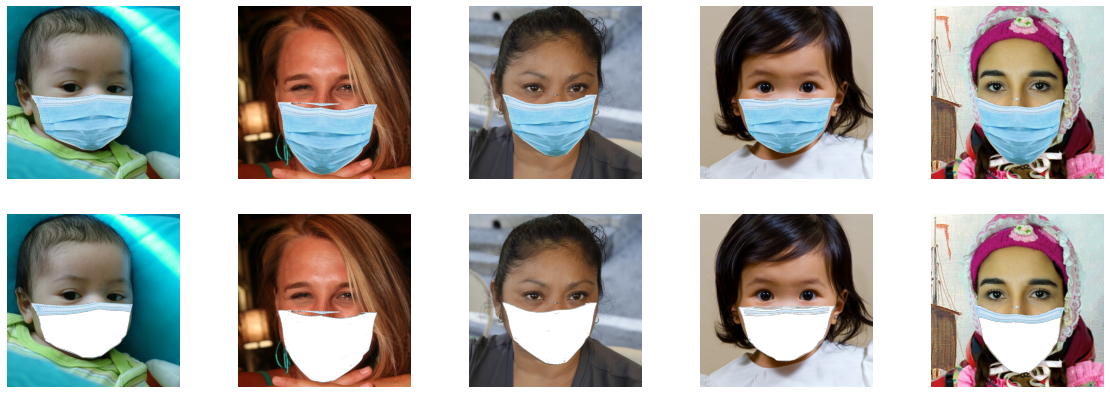

In [11]:
# parameters
num_faces = 350
masked_dir = '../data/masked_projection'
transparent_dir = '../data/transparent'

# confirm that data directories exist
assert os.path.isdir(masked_dir)
assert os.path.isdir(transparent_dir)

# load training data
img_size = 128
masked_faces = torch.zeros((num_faces, 3, img_size, img_size))
transparent_faces = torch.zeros((num_faces, 1, img_size, img_size))
plt.figure()
fig, axes = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(7)
face_id = 0
skipped = 0
idx_to_face_id = []
while face_id < num_faces and skipped < num_faces:
    # get image paths
    face_id_text = str(100000 + face_id + skipped)[1:]
    masked_path = '{}/{}_Mask.jpg'.format(masked_dir, face_id_text)
    transparent_path = '{}/{}_Mask.png'.format(transparent_dir, face_id_text)
    
    # load images
    try:
        masked_img = Image.open(masked_path)
        transparent_img = Image.open(transparent_path)
    except:  # skip missing images
        skipped += 1
        continue
        
    # process images
    masked_tensor = Resize((img_size,img_size))(ToTensor()(masked_img)) - .5
    transparent_tensor = Resize((img_size,img_size))(ToTensor()(transparent_img))[3,:,:]
    if masked_tensor is None or transparent_tensor is None:
        skipped += 1
        continue
        
    # display images
    if face_id < 5:
        axes[0,face_id].imshow(masked_img)
        axes[0,face_id].set_axis_off()
        axes[1,face_id].imshow(transparent_img)
        axes[1,face_id].set_axis_off()
    
    # save images to respective tensors
    masked_faces[face_id] = masked_tensor
    transparent_faces[face_id] = transparent_tensor
    idx_to_face_id.append(face_id_text)
    face_id += 1
    
# warn that `num_faces` is too large
if skipped > num_faces:
    print("NOTE: `num_faces` is larger than total capacity of chosen directories ({}, {})".format(masked_dir, transparent_dir))
    
# split data into training and testing sets
split = int(.8 * num_faces)
train_input, train_output = masked_faces[:split,:,:,:], transparent_faces[:split,:,:]
test_input, test_output = masked_faces[split:,:,:,:], transparent_faces[split:,:,:]

In [18]:
# instantiate projector
from gan import Projector
projector = Projector(learning_rate=6.5e-4)

# load weights
load = False
load_path = '../models/projector.pt'
if load:
    projector.load_state_dict(torch.load(load_path))

In [20]:
# fit projector to training data and evaluate loss on test data
train_loss = projector.fit(train_input, train_output, num_epochs=50)
projector.learning_rate = 1e-4
train_loss = projector.fit(train_input, train_output, num_epochs=50)

# evaluate test data and output result
test_loss = projector.evaluate(test_input, test_output)
print('\nfinal training loss: {}'.format(train_loss))
print('final test loss: {}'.format(test_loss))
print('bias: {}'.format(train_loss))
print('variance: {}'.format(test_loss - train_loss))

Epoch 10 loss: 0.0002907661597847062
Epoch 20 loss: 0.00027163333930623005
Epoch 30 loss: 0.0002684950005085043
Epoch 40 loss: 0.0002712243174969712
Epoch 50 loss: 0.0002583306435125825

final training loss: 0.0002583306435125825
final test loss: 4.1316359836075984e-05
bias: 0.0002583306435125825
variance: -0.0002170142836765065


Text(0.5, 0, 'processed transparency mask')

<Figure size 432x288 with 0 Axes>

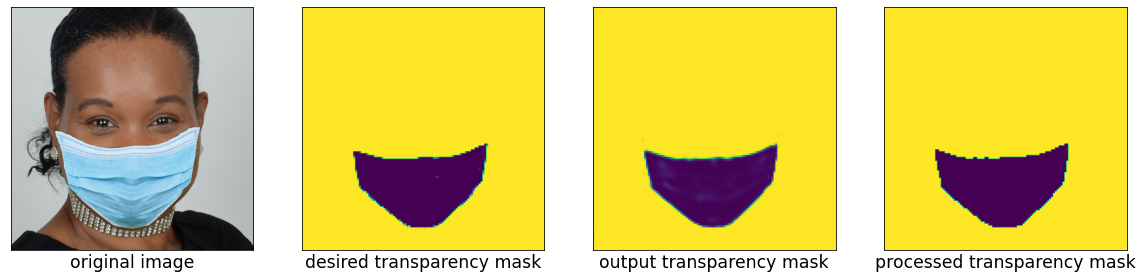

In [35]:
# parameters
face_idx = 325

# display outputs
plt.figure()
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.set_figheight(7)

# display original image
face_id_text = idx_to_face_id[face_idx]
original_img = Image.open('../data/masked_projection/{}_Mask.jpg'.format(face_id_text))
axes[0].imshow(original_img)
axes[0].get_xaxis().set_ticks([])
axes[0].get_yaxis().set_ticks([])
axes[0].set_xlabel('original image', fontsize='xx-large')

# display desired transparency mask
desired_mask = torch.transpose(transparent_faces[face_idx,:,:], 0, 2)
desired_mask = torch.transpose(desired_mask, 0, 1)
axes[1].imshow(desired_mask)
axes[1].get_xaxis().set_ticks([])
axes[1].get_yaxis().set_ticks([])
axes[1].set_xlabel('desired transparency mask', fontsize='xx-large')

# display output transparency mask
output_mask = projector.predict(torch.unsqueeze(masked_faces[face_idx,:,:,:], 0))[0]
output_mask = torch.transpose(output_mask, 0, 2)
output_mask = torch.transpose(output_mask, 0, 1)
output_mask = output_mask.detach().numpy()
axes[2].imshow(output_mask)
axes[2].get_xaxis().set_ticks([])
axes[2].get_yaxis().set_ticks([])
axes[2].set_xlabel('output transparency mask', fontsize='xx-large')

# display processed transparency mask
avg = np.mean(output_mask)
avg_mask = (output_mask > avg).astype('int')
axes[3].imshow(avg_mask)
axes[3].get_xaxis().set_ticks([])
axes[3].get_yaxis().set_ticks([])
axes[3].set_xlabel('processed transparency mask', fontsize='xx-large')

In [29]:
# save projector model
save_path = '../models/projector.pt'
torch.save(projector.state_dict(), save_path)